# 2.2.10 スペースシャトル「チャレンジャー号」の悲劇

In [1]:
using Distributed
addprocs(3)

using CSV
using DataFrames
using HTTP
using LaTeXStrings
@everywhere using Mamba
using Plots

[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl


## データの取得 & 加工

In [2]:
r = HTTP.request("GET", "https://git.io/vXknD");

In [3]:
challengers_data = CSV.read(IOBuffer(r.body))
names!(challengers_data, [:date, :temperature, :incident])
# incidentのパース
challengers_data[:incident] = tryparse.(Int64, challengers_data[:incident])
# NaNを削除
challengers_data = challengers_data[challengers_data[:incident] .!= nothing, :]
challengers_data[:incident] = convert.(Int64, challengers_data[:incident])
disallowmissing!(challengers_data)

,date,temperature,incident
,String,Int64,Int64
1,04/12/1981,66,0
2,11/12/1981,70,1
3,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


In [4]:
temperature = challengers_data[:temperature]
color_weight = (temperature .- minimum(temperature)) ./ (maximum(temperature) .- minimum(temperature))

23-element Array{Float64,1}:
 0.4642857142857143 
 0.6071428571428571 
 0.5714285714285714 
 0.5357142857142857 
 0.5                
 0.6785714285714286 
 0.7142857142857143 
 0.6071428571428571 
 0.14285714285714285
 0.35714285714285715
 0.6071428571428571 
 0.8928571428571429 
 0.5                
 0.0                
 0.5                
 0.7857142857142857 
 0.6071428571428571 
 1.0                
 0.8214285714285714 
 0.9285714285714286 
 0.7857142857142857 
 0.8214285714285714 
 0.17857142857142858

## データの図示

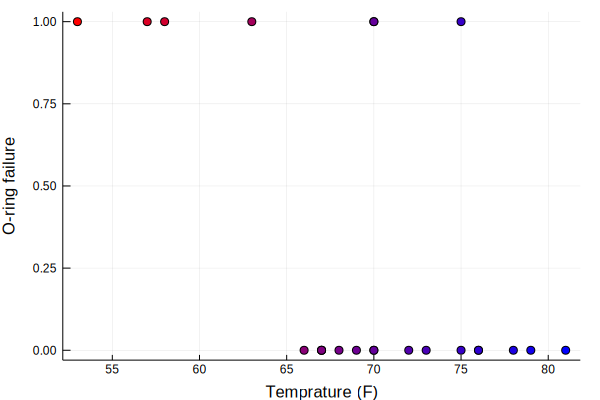

In [5]:
scatter(challengers_data.temperature, challengers_data.incident, 
        markercolor = weighted_color_mean.(color_weight, colorant"blue", colorant"red"), 
        xlabel = "Temprature (F)", ylabel = "O-ring failure", label = "")

## ロジスティック関数を表示する

In [6]:
function logistic(x, alpha, beta)
    1.0 / (1.0 + exp(beta * x + alpha))
end

logistic (generic function with 1 method)

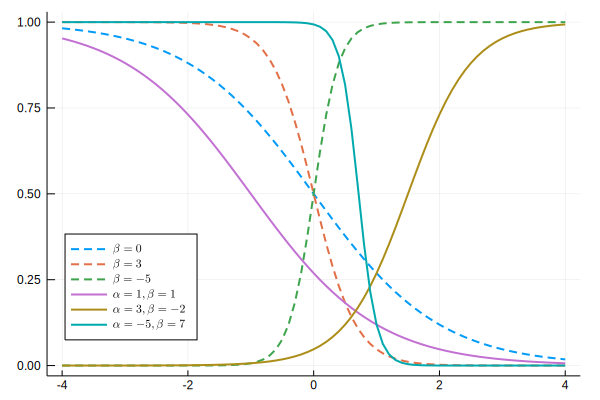

In [7]:
x = -4:0.1:4
Plots.plot(x, logistic.(x, 0, 1), linestyle = :dash, linewidth = 2, label = L"\beta = 0",
    legend = :bottomleft)
Plots.plot!(x, logistic.(x, 0, 3), linestyle = :dash, linewidth = 2, label = L"\beta = 3")
Plots.plot!(x, logistic.(x, 0, -5), linestyle = :dash, linewidth = 2, label = L"\beta = -5")
Plots.plot!(x, logistic.(x, 1, 1), linewidth = 2, label = L"\alpha = 1, \beta = 1")
Plots.plot!(x, logistic.(x, 3, -2), linewidth = 2, label = L"\alpha = 3, \beta = -2")
Plots.plot!(x, logistic.(x, -5, 7), linewidth = 2, label = L"\alpha = -5, \beta = 7")

## チャレンジャー号のモデリング

In [8]:
model = Model(
    
    observed = Stochastic(1,
        (alpha, beta, temperature) -> 
            UnivariateDistribution[
                Bernoulli(1.0 / (1.0 + exp(beta * x + alpha)))
            for x in temperature],
        false
    ),
    
    alpha = Stochastic(() -> Normal(0, sqrt(1000))),
    beta = Stochastic(() -> Normal(0, sqrt(1000))),

)

Object of type "Model"
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
observed:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [9]:
data = Dict{Symbol, Any}(
    :observed => challengers_data[:incident],
    :temperature => challengers_data[:temperature],
)

Dict{Symbol,Any} with 2 entries:
  :temperature => [66, 70, 69, 68, 67, 72, 73, 70, 57, 63  …  53, 67, 75, 70, 8…
  :observed    => [0, 1, 0, 0, 0, 0, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 1, 0, …

In [10]:
inits = [
    Dict{Symbol, Any}(
        :observed => challengers_data[:incident],
        :alpha => 0,
        :beta => 0,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha=>0,:beta=>0,:p=>[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],:observed=>[0, 1, 0, 0, 0, 0, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 1, 0, 1])
 Dict(:alpha=>0,:beta=>0,:p=>[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],:observed=>[0, 1, 0, 0, 0, 0, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 1, 0, 1])
 Dict(:alpha=>0,:beta=>0,:p=>[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],:observed=>[0, 1, 0, 0, 0, 0, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [11]:
scheme = [AMWG([:alpha, :beta], 1.0)]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:alpha, :beta]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [40]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 200000, burnin = 100000, thin = 40, chains = 3)

MCMC Simulation of 200000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [0:00:20 of 0:00:20 remaining]
      From worker 4:	Chain 2:   0% [0:00:18 of 0:00:18 remaining]
      From worker 3:	Chain 3:   0% [0:00:17 of 0:00:17 remaining]
      From worker 2:	Chain 1:  10% [0:00:16 of 0:00:18 remaining]
      From worker 3:	Chain 3:  10% [0:00:17 of 0:00:19 remaining]
      From worker 4:	Chain 2:  10% [0:00:17 of 0:00:19 remaining]
      From worker 2:	Chain 1:  20% [0:00:13 of 0:00:17 remaining]
      From worker 4:	Chain 2:  20% [0:00:14 of 0:00:17 remaining]
      From worker 3:	Chain 3:  20% [0:00:14 of 0:00:17 remaining]
      From worker 2:	Chain 1:  30% [0:00:11 of 0:00:16 remaining]
      From worker 3:	Chain 3:  30% [0:00:12 of 0:00:17 remaining]
      From worker 4:	Chain 2:  30% [0:00:12 of 0:00:17 remaining]
      From worker 2:	Chain 1:  40% [0:00:10 of 0:00:16 remaining]
      From worker 3:	Chain 3:  40% [0:00:10 of 0:00:16 remaining]
      From worker 4:	Cha

Object of type "ModelChains"

Iterations = 100040:200000
Thinning interval = 40
Chains = 1,2,3
Samples per chain = 2500

[0.280911 -18.2769; 0.298704 -19.8486; … ; 0.140182 -8.51933; 0.139619 -8.41209]

[0.385547 -26.0077; 0.430001 -29.7834; … ; 0.330603 -21.4181; 0.385469 -25.1962]

[0.499967 -33.5743; 0.517282 -33.2547; … ; 0.195498 -11.8658; 0.200041 -13.1988]

In [41]:
describe(sim)

Iterations = 100040:200000
Thinning interval = 40
Chains = 1,2,3
Samples per chain = 2500

Empirical Posterior Estimates:
          Mean         SD       Naive SE       MCSE        ESS   
 beta   0.29044402 0.11459103 0.0013231833 0.010234621 125.359634
alpha -18.95232518 7.80647560 0.0901414158 0.694965890 126.177824

Quantiles:
          2.5%         25.0%        50.0%       75.0%       97.5%   
 beta   0.07675045   0.21945226   0.28900463   0.3569502  0.52699968
alpha -35.00311842 -23.45969532 -18.84033243 -14.1296279 -4.31961973



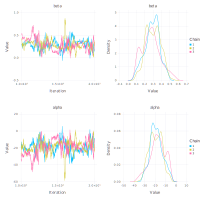

In [42]:
p = Mamba.plot(sim, legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

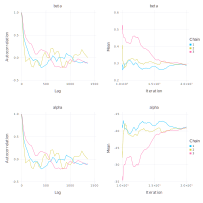

In [43]:
p = Mamba.plot(sim, [:autocor, :mean], legend=true)
Mamba.draw(p, nrow = 2, ncol = 2)

In [44]:
gelmandiag(sim, mpsrf = true, transform = true)

              PSRF 97.5%
        beta 1.010 1.011
       alpha 1.009 1.010
Multivariate 1.000   NaN

